## <center>Churn Modelling, notatnik III<center/>
<center>Projekt zaliczeniowy Praktyczny Machine Learning w Pythonie <br/>
Autor: Maciej Odziemczyk (388581)<br/>
Wydział Nauk Ekonomicznych UW<br/>
czerwiec 2020 <center/>

##### Spis treści:
 - wykorzystanie zbiorów danych z Notatnika II, label encoding tam gdzie to konieczne,
 - porównanie sieci neuronowych na zmiennych standardowych i będących wynikiem Notatnika II (poprawa wyników o kilka %),
 - praca z sieciami neuronowymi w zakresie pokazanym na zajęciach:
     - zbadanie przebiegu procesu uczenia w zależności od optymalizatora,
     - zbadanie przebiegu procesu uczenia w zależności od batch size,
     - zbadanie przebiegu procesu uczenia w zależności od funkcji aktywacji,
     - zbadanie przebiegu procesu uczenia w zależności od zastosowanej regularyzacji,
     - zbadanie przebiegu procesu uczenia w zależności od zastosowanego dropoutu,
     - walidacja krzyżowa i wybór najlepszej sieci,
 - zestawienie wyników wszystkich modeli (bez KNN i SVM - były zbyt słabe i nie zostało im poświęcone dużo uwagi),
 - sprawdzenie zróżnicowania predykcji dokonywanych przez najlepsze modele,
 - regresja logistyczna targetu na predykcjach z modeli,
 - ensembling:
     - próba zwykłej średniej (nieudana),
     - symulacja po zawężeniu wag, 10 000 iteracji losowych wag,
 - wnioski.

In [ ]:
import time
kernelstart = time.time()

In [30]:
# import bibliotek
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing.text import Tokenizer
from keras.layers.advanced_activations import PReLU


from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
#from sklearn import metrics
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
from sklearn import preprocessing

import time
import pickle

In [4]:
# wczytanie zbiorów danych
with open("df.p", "rb") as fp:
    df = pickle.load(fp)
    
with open("dffin.p", "rb") as fp:
    dffin = pickle.load(fp)

##### Przygotowanie danych dla sieci (label encoding)

In [11]:
num = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Tenure']
# tenure można rozpatrywać jako kategorie, jednak ja nie chcę jej dekodować w ten sposób, zachowuję ją
# jako zmienną uporządkowaną

In [14]:
# zmienne kategoryzujące
cat = [i for i in df.columns.tolist() if i not in num]

# Kopiowanie obiektu
dfl = df.copy()
# Słownik zawierający mapy
mapy = {}
for feature in cat:
    # Inicjacja obiektu do kodowania, który będzie przechowywał mapę
    le = preprocessing.LabelEncoder()
    # Dopasowanie kolumny (tworzenie mapy) i od razu jej nałożenie na zmienną, na której dokonane zostało dopasowanie
    dfl[feature] = le.fit_transform(df[feature])
    # Zapis mapy, aby móc odzyskać informację o mapowaniu i oryginalnych wartościach
    mapy[feature] = le
    
features = dfl.columns.tolist()
features.remove('Exited')
print(features)

['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']


In [15]:
# Sprawdzenie klas dla Geography
print(mapy['Geography'].classes_)

print('Wszystko ok:', 
pd.Series(df["Geography"].values).equals( # seria z oryginalnego df
    pd.Series(mapy['Geography'].inverse_transform(dfl["Geography"])))) # seria z kopii po odzyskaniu labeli

['France' 'Germany' 'Spain']
Wszystko ok: True


##### wrapper

In [17]:
# Funkcja pomocnicza,która pozwoli nam również zaawansowane funkcje aktywacji wybierać po imieniu
def actModel(model, activation):
    if activation=='prelu':
        model.add(keras.layers.advanced_activations.PReLU(weights=None, alpha_initializer="zero"))
    else:
        model.add(Activation(activation))
    return


# Wydzielona funkcja, która odpowiada wyłącznie za budowę sieci.
def create_network(n=3, nu1=10, nu2=5, nu3=5,
                   activation='relu',
                   dropout=Dropout,
                   dropout_rate=0,
                   regu=0,
                   kernel_initializer='lecun_normal',
                   optimizer='SGD',
                   num_classes=1, 
                  inputShape=10, dropout_all_layers = False, debug=False, *args, **kwargs):
    nu=[nu1, nu2, nu3]
    # Jeżeli włączony jest tryb debug wyświetlimy parametry funkcji
    if debug:
        print(locals())
        
    # Inicjacja podstawowego modelu keras w trybie sekwencyjnym
    # W ten sposób najłatwiej zbutować w pełni połączone sieci feed forward.
    model = Sequential()
    
    # Definicja inputów do sieci oraz pierwszej warstwy
    # nu[0] odpowiada za liczbę neuronów w pierwszej warstwie
    # dodatkowo ustalamy jak inicjalizować parametry raz czy stosować refularyzację.
    model.add(Dense(nu[0],input_shape=(inputShape,),
                    kernel_initializer=kernel_initializer, kernel_regularizer=regularizers.l2(regu)))
                    #regularizers.l2(regu)))
    
    # Dodanie funkcji aktywacji do pierwszej warstwy.
    actModel(model, activation)
    
    # Opcjonalne włączenie mechanizmu dropout
    if dropout_rate > 0.01:
        model.add(dropout(dropout_rate))
    
    # Kolejne warstwy budowane są w ten sam sposób, co pozwala budować je w pętli
    # Pierwsza warstwa jako jedyna musiała mieć zdefiniowany input
    # W pozostałych warstwach model automatycznie keras połączy warstwy,
    # Input do kolejnej warstwy będzie outputem z wcześniejszych warstw.
    for i in range(1, n):
        # Inicjalizacja warstwy przez potanie liczby neuronów oraz sposobu inicjacji
        model.add(Dense(nu[i], kernel_initializer=kernel_initializer))
        # Definicja funkcji aktywacji
        actModel(model, activation)
        
        # Opcjonalne dodanie dropout
        if dropout_rate > 0.01 and dropout_all_layers:
            model.add(dropout(dropout_rate))

    # Aby "zakończyć" sieć niezbędne jest przygotowanie odpowiedniej liczby neuronów
    # Wystarczy jeden neuron dla regresji
    # Dla klasyfikacji binarnej oraz wieloklasowej potrzeba tyle neuronów co klas.
    # Dla binarnej będą to dwa neurony.
    # W przypadku klasyfikacji wieloklasowej target musi być również podany w postaci one- hot encoding.
    model.add(Dense(num_classes))
    
    # Dla klasyfikacji binarnej lub wieloklasowej jako funkcję aktywacji stosujemy softmax
    # Będzie on odpowiadał transformacji logistycznej.
    # W problemie regresji możemy po prostu wykorzystać funkcję liniową.
    # Na chwilę obecną budujemy wrapper dla klasyfikacji binarnej
    # Poniżej pozostawiamy softmax, z funkcją straty categorical_crossentropy oraz accuracy jak bazową metryką.
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

In [34]:
from sklearn.metrics import roc_auc_score
# Funkcja net będzie naszym wrapperem do budowania siecie, trenowania, oraz zbierania wyników/statystyk.
def net(train, test, features, target='Exited', epochs = 30, batchSize=100, debug=False, *args, **kwargs):
    
    # Przygotowanie zmiennych
    y_train = pd.get_dummies(train[target]).values
    y_test = pd.get_dummies(test[target]).values
    x_train = train[features].values
    x_test = test[features].values
    
    num_classes = y_train.shape[1]
    
    # Wyświetlenie informacji opisowych jeżeli jesteśmy w trybie debugowym
    if debug:
        print('Loading data...')
        print(len(x_train), 'train sequences')
        print(len(x_test), 'test sequences')
        print(num_classes, 'classes')
        print('x_train shape:', x_train.shape)
        print('x_test shape:', x_test.shape)
        print('\nBuilding network 1...')
    
    # Stworzenie modelu z użyciem funkcji create_network.
    model = create_network(num_classes=num_classes, inputShape=x_train.shape[1], debug=debug, *args, **kwargs)
    
    # Przygotowanie zmiennych do przechowywania statystyk dotyczących szkolenia
    history_model = dict()
    loss = []
    valLoss = []
    acc = []
    valAcc = []
    auc = []
    valAuc = []
    pr = []
    valpr = []
    
    
    bestTrainProba = []
    bestTestProba = []
    bestPr = 0
    # Iteracyjne uruchomienie szkolenia.
    for z in range(epochs):
        # Wykonaj jedną iterację szkolenia
        histModel = model.fit(x_train,
                                    y_train,
                                    batch_size=batchSize,
                                    epochs=1,
                                    verbose=debug,
                                    validation_split=0.0,
                                   validation_data=(x_test, y_test))
        # Zrób prognozę na zbiorze treningowym
        probaTrain = model.predict(x_train,
                                       batch_size=y_train.shape[0],
                                       verbose=debug)
        # Zrób prognozę na zbiorze testowym
        probaTest = model.predict(x_test,
                                       batch_size=y_test.shape[0],
                                       verbose=debug)
        # Obliczenie statystyk AUC
        # We wcześniejszych wersjach Keras nie miał wbudowanego liczenia auc pomiędzy iteracjami
        aucTrain = roc_auc_score(train[target], probaTrain[:,1])
        aucTest = roc_auc_score(test[target], probaTest[:,1])
        prTrain = average_precision_score(train[target], probaTrain[:,1])
        prTest = average_precision_score(test[target], probaTest[:,1])
        
        if debug:
            print('{}\nROCtrain: {}\nROCtest: {}\nPRtrain: {}\nPRtest:{}\n{}'.format(
                '-'*30,aucTrain, aucTest, prTrain, prTest, '-'*30))
            
        # Ręczna implementacja zapisywania prognoz z najlepszej iteracji
        if prTest>bestPr:
            bestPr = prTest
            bestTrainProba = probaTrain[:, 1].tolist()
            bestTestProba = probaTest[:, 1].tolist()
        
        
        # Zapisanie wyników w tej iteracji
        loss.append(histModel.history['loss'][0])
        valLoss.append(histModel.history['val_loss'][0])
        acc.append(histModel.history['accuracy'][0])
        valAcc.append(histModel.history['val_accuracy'][0])
        auc.append(aucTrain)
        valAuc.append(aucTest)
        pr.append(prTrain)
        valpr.append(prTest)
        
    # Zapisanie wyników ze wszystkich iteracji do słownika
    history_model['loss'] = loss
    history_model['valLoss'] = valLoss
    history_model['acc'] = acc
    history_model['valAcc'] = valAcc
    history_model['auc'] = auc
    history_model['valAuc'] = valAuc
    history_model['pr'] = pr
    history_model['valpr'] = valpr
    return valAuc[valpr.index(max(valpr))], max(valpr), bestTrainProba, bestTestProba, history_model

In [35]:
# zmienne standardowe
features_standard = dfl.columns.tolist()
features_standard.remove('Exited')

# zmienne po EDA
features_eng = dffin.columns.tolist()
features_eng.remove('Exited')

In [59]:
# sieć na standardowych zmiennych (ale znormalizowanych/zunitaryzowanych)
test_size=0.3
X_train, X_valid = train_test_split(dfl, test_size=test_size, random_state=2020, stratify=dfl.Exited.values)
ROC, PR, bestTrainProba, bestTestProba, history = net(X_train, X_valid, features_standard, n=2, nu1=100, nu2=40, n3 = 10,
                                                    epochs = 50, batchSize=50, debug=True)
print(ROC, PR)

Loading data...
7000 train sequences
3000 test sequences
2 classes
x_train shape: (7000, 10)
x_test shape: (3000, 10)

Building network 1...
{'n': 2, 'nu1': 100, 'nu2': 40, 'nu3': 5, 'activation': 'relu', 'dropout': <class 'keras.layers.core.Dropout'>, 'dropout_rate': 0, 'regu': 0, 'kernel_initializer': 'lecun_normal', 'optimizer': 'SGD', 'num_classes': 2, 'inputShape': 10, 'dropout_all_layers': False, 'debug': True, 'args': (), 'kwargs': {'n3': 10}, 'nu': [100, 40, 5]}
Train on 7000 samples, validate on 3000 samples
Epoch 1/1
3000/3000 [==============================] - 0s 1us/step
------------------------------
ROCtrain: 0.7229647290490663
ROCtest: 0.7188964148966999
PRtrain: 0.3821842652962205
PRtest:0.37727401376317554
------------------------------
Train on 7000 samples, validate on 3000 samples
Epoch 1/1
3000/3000 [==============================] - 0s 0us/step
------------------------------
ROCtrain: 0.7500391896659052
ROCtest: 0.7457002532748638
PRtrain: 0.4374805858571124
PRtes

3000/3000 [==============================] - 0s 1us/step
------------------------------
ROCtrain: 0.826101047188132
ROCtest: 0.8050811171497294
PRtrain: 0.6142584657564992
PRtest:0.5834621406126251
------------------------------
Train on 7000 samples, validate on 3000 samples
Epoch 1/1
3000/3000 [==============================] - 0s 0us/step
------------------------------
ROCtrain: 0.8279167931052357
ROCtest: 0.8060703757469965
PRtrain: 0.6188167203457557
PRtest:0.5865025242864288
------------------------------
Train on 7000 samples, validate on 3000 samples
Epoch 1/1
3000/3000 [==============================] - 0s 3us/step
------------------------------
ROCtrain: 0.8306374869095192
ROCtest: 0.8077426612289414
PRtrain: 0.6227290939357296
PRtest:0.593253151470112
------------------------------
Train on 7000 samples, validate on 3000 samples
Epoch 1/1
3000/3000 [==============================] - 0s 1us/step
------------------------------
ROCtrain: 0.8343652230275709
ROCtest: 0.8099787693

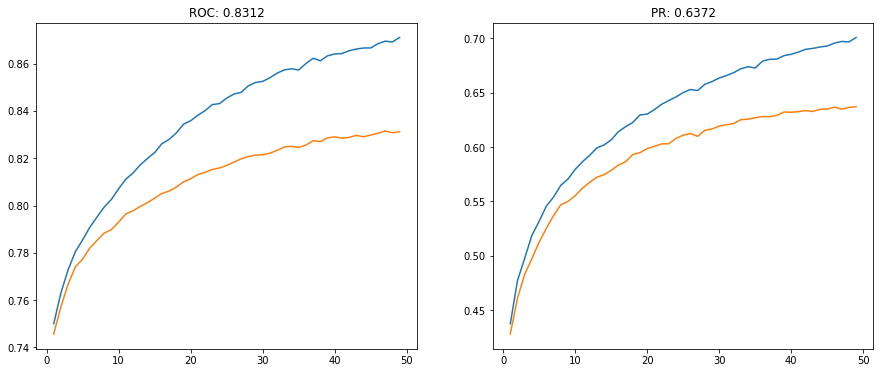

In [60]:
history = pd.DataFrame(history)
f, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,6))
ax[0].plot(history.loc[1:, ["auc", "valAuc"]])
ax[0].set_title('ROC: {}'.format(round(ROC, 4)))
ax[1].plot(history.loc[1:, ["pr", "valpr"]])
ax[1].set_title('PR: {}'.format(round(PR, 4)))
plt.show()

In [57]:
# sieć na zmiennych z EDA
test_size=0.3
X_train, X_valid = train_test_split(dffin, test_size=test_size, random_state=2020, stratify=dffin['Exited'].values)
ROC, PR, bestTrainProba, bestTestProba, history = net(X_train, X_valid, features_eng, n=2, nu1=100, nu2=40, nu3 = 10,
                                                    epochs = 50, batchSize=50, debug=True)
print(ROC, PR)

Loading data...
7000 train sequences
3000 test sequences
2 classes
x_train shape: (7000, 15)
x_test shape: (3000, 15)

Building network 1...
{'n': 2, 'nu1': 100, 'nu2': 40, 'nu3': 10, 'activation': 'relu', 'dropout': <class 'keras.layers.core.Dropout'>, 'dropout_rate': 0, 'regu': 0, 'kernel_initializer': 'lecun_normal', 'optimizer': 'SGD', 'num_classes': 2, 'inputShape': 15, 'dropout_all_layers': False, 'debug': True, 'args': (), 'kwargs': {}, 'nu': [100, 40, 10]}
Train on 7000 samples, validate on 3000 samples
Epoch 1/1
3000/3000 [==============================] - 0s 0us/step
------------------------------
ROCtrain: 0.7366690973066194
ROCtest: 0.737004505785176
PRtrain: 0.4307654321135033
PRtest:0.43315972082703413
------------------------------
Train on 7000 samples, validate on 3000 samples
Epoch 1/1
3000/3000 [==============================] - 0s 1us/step
------------------------------
ROCtrain: 0.7754092457920488
ROCtest: 0.7714428994319984
PRtrain: 0.5015698581949632
PRtest:0.491

3000/3000 [==============================] - 0s 1us/step
------------------------------
ROCtrain: 0.8745456389135895
ROCtest: 0.8407101835403537
PRtrain: 0.7084766471047244
PRtest:0.6490936635103614
------------------------------
Train on 7000 samples, validate on 3000 samples
Epoch 1/1
3000/3000 [==============================] - 0s 1us/step
------------------------------
ROCtrain: 0.8748522367171565
ROCtest: 0.8408362386524708
PRtrain: 0.70976666356605
PRtest:0.6510004854488972
------------------------------
Train on 7000 samples, validate on 3000 samples
Epoch 1/1
3000/3000 [==============================] - 0s 0us/step
------------------------------
ROCtrain: 0.8750128954759399
ROCtest: 0.8400038638632192
PRtrain: 0.7107346776461535
PRtest:0.6502137761505397
------------------------------
Train on 7000 samples, validate on 3000 samples
Epoch 1/1
3000/3000 [==============================] - 0s 1us/step
------------------------------
ROCtrain: 0.8759243225534703
ROCtest: 0.8418186464

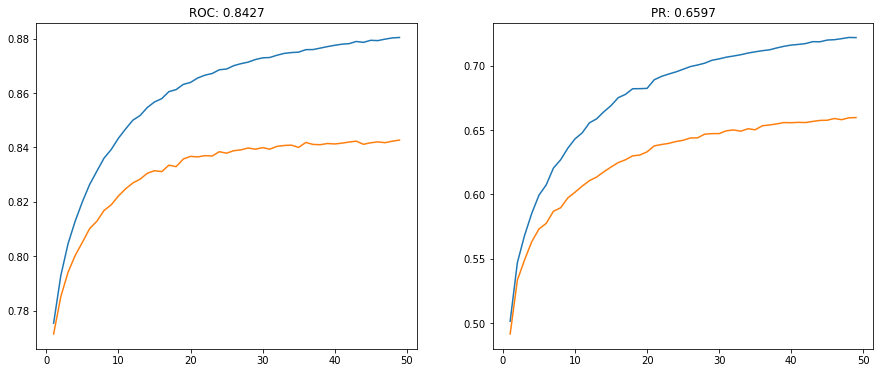

In [58]:
history = pd.DataFrame(history)
f, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,6))
ax[0].plot(history.loc[1:, ["auc", "valAuc"]])
ax[0].set_title('ROC: {}'.format(round(ROC, 4)))
ax[1].plot(history.loc[1:, ["pr", "valpr"]])
ax[1].set_title('PR: {}'.format(round(PR, 4)))
plt.show()

Widać, że feature engineering przyniósł rezultaty na sieci neuronowej, co prawda jest to jeden fold, ale nie ma w tym wypadku podstaw do wyboru standardowych zmiennych. Oczywiście, przetrenowanie jest większe, ale będzie można je zredukować za pomocą hiperparametrów.<br/>
##### Optymalizatory

SGD, PR: 0.6604383413567483
SGD, ROC: 0.8449823557097143
------------------------------
RMSprop, PR: 0.668638457591158
RMSprop, ROC: 0.8424215187037698
------------------------------
Adagrad, PR: 0.6735272359743653
Adagrad, ROC: 0.8453153056254149
------------------------------
Adadelta, PR: 0.6715536479769104
Adadelta, ROC: 0.8441951963411134
------------------------------
Adam, PR: 0.6789051164867314
Adam, ROC: 0.8448556155154661
------------------------------
Adamax, PR: 0.6655196774393894
Adamax, ROC: 0.8408410342273883
------------------------------


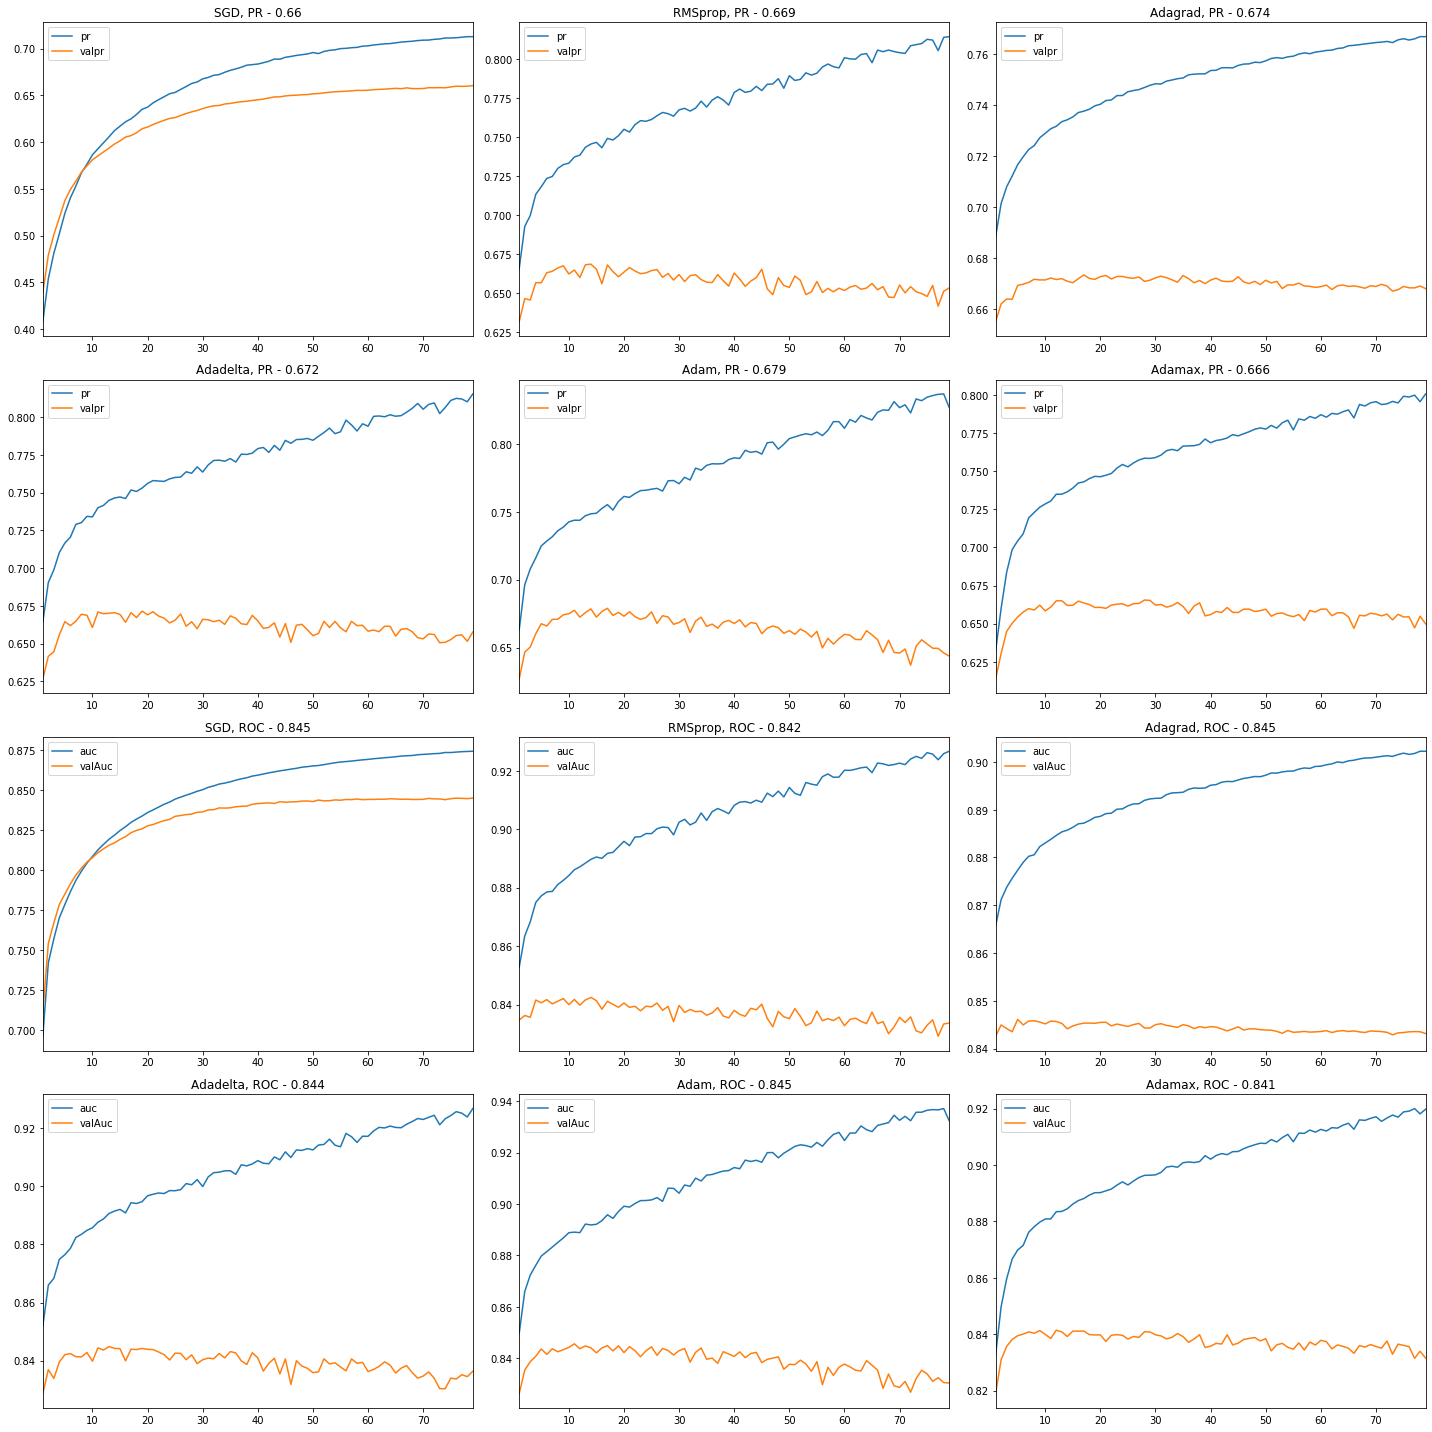

In [61]:
opti = ["SGD", "RMSprop", "Adagrad", "Adadelta", "Adam", "Adamax"]
test_size=0.3
X_train, X_valid = train_test_split(dffin, test_size=test_size, random_state=2020, stratify=dffin['Exited'].values)

fig, ax = plt.subplots(4, 3, figsize=(20,20))
ax = ax.flatten()

n = 2
nu1 = 100
nu2 = 40
nu3 = 10

for i, opt in enumerate(opti):
    ROC, PR, bestTrainProba, bestTestProba, history = net(X_train, X_valid, features_eng, n=n, nu1=nu1, nu2=nu2, nu3=nu3,
                                    epochs = 80, batchSize=100, optimizer=opt, debug=False)
    print('{}, PR: {}'.format(opt, PR))
    history = pd.DataFrame(history)
    history.loc[1:, ["pr", "valpr"]].plot(ax = ax[i])
    ax[i].set_title(opt+ ", PR - " + str(round(PR, 3)))
    
    print('{}, ROC: {}'.format(opt, ROC))
    history = pd.DataFrame(history)
    history.loc[1:, ["auc", "valAuc"]].plot(ax = ax[i+6])
    ax[i+6].set_title(opt+ ", ROC - " + str(round(ROC, 3)))
    print('-'*30)

plt.tight_layout()
plt.show()

Poza SGD właściwie tylko Adamax wygląda okej (szczególnie na ROC, na PR jest trochę gorzej)

SGD, PR: 0.6622969188341886
SGD, ROC: 0.8410999952729332
------------------------------
RMSprop, PR: 0.6660022051780883
RMSprop, ROC: 0.8419494971154617
------------------------------
Adagrad, PR: 0.6702292653824657
Adagrad, ROC: 0.8426928112276741
------------------------------
Adadelta, PR: 0.6627767535248639
Adadelta, ROC: 0.8411986470998075
------------------------------
Adam, PR: 0.6517165904323367
Adam, ROC: 0.8351798580372809
------------------------------
Adamax, PR: 0.6645274300456605
Adamax, ROC: 0.8428469547071651
------------------------------


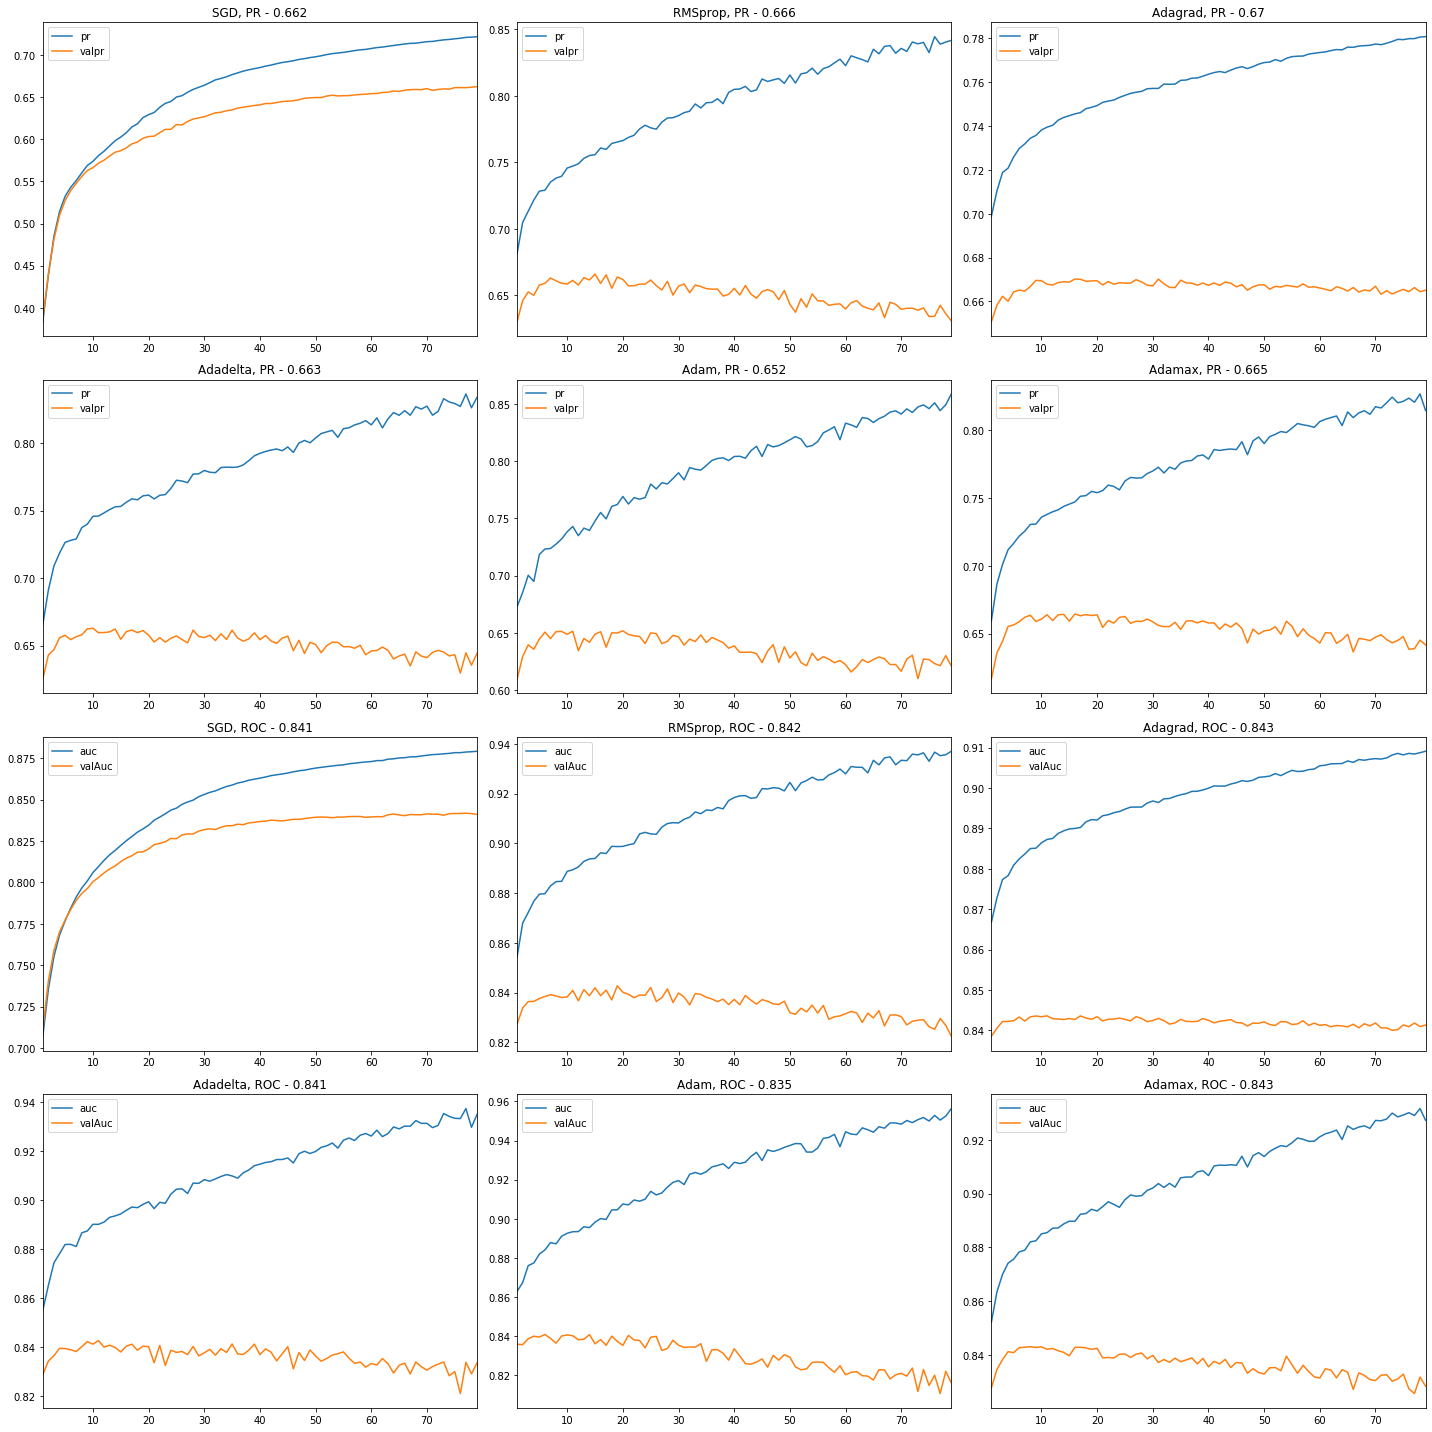

In [62]:
opti = ["SGD", "RMSprop", "Adagrad", "Adadelta", "Adam", "Adamax"]
test_size=0.3
X_train, X_valid = train_test_split(dffin, test_size=test_size, random_state=2020, stratify=dffin['Exited'].values)

fig, ax = plt.subplots(4, 3, figsize=(20,20))
ax = ax.flatten()

n = 3
nu1 = 100
nu2 = 40
nu3 = 10

for i, opt in enumerate(opti):
    ROC, PR, bestTrainProba, bestTestProba, history = net(X_train, X_valid, features_eng, n=n, nu1=nu1, nu2=nu2, nu3=nu3,
                                    epochs = 80, batchSize=100, optimizer=opt, debug=False)
    print('{}, PR: {}'.format(opt, PR))
    history = pd.DataFrame(history)
    history.loc[1:, ["pr", "valpr"]].plot(ax = ax[i])
    ax[i].set_title(opt+ ", PR - " + str(round(PR, 3)))
    
    print('{}, ROC: {}'.format(opt, ROC))
    history = pd.DataFrame(history)
    history.loc[1:, ["auc", "valAuc"]].plot(ax = ax[i+6])
    ax[i+6].set_title(opt+ ", ROC - " + str(round(ROC, 3)))
    print('-'*30)

plt.tight_layout()
plt.show()

Na trójwarstwowych sieciach jest gorzej i lepiej byloby wybrać SGD.
##### Batch size

SGD, batch: 50, PR: 0.6620983155486339
SGD, batch: 100, PR: 0.662039178962334
SGD, batch: 200, PR: 0.6211784709236872
SGD, batch: 500, PR: 0.5851964179479521
Adamax, batch: 50, PR: 0.6707993284215344
Adamax, batch: 100, PR: 0.6728217364580705
Adamax, batch: 200, PR: 0.6713972608749622
Adamax, batch: 500, PR: 0.6703238437498382


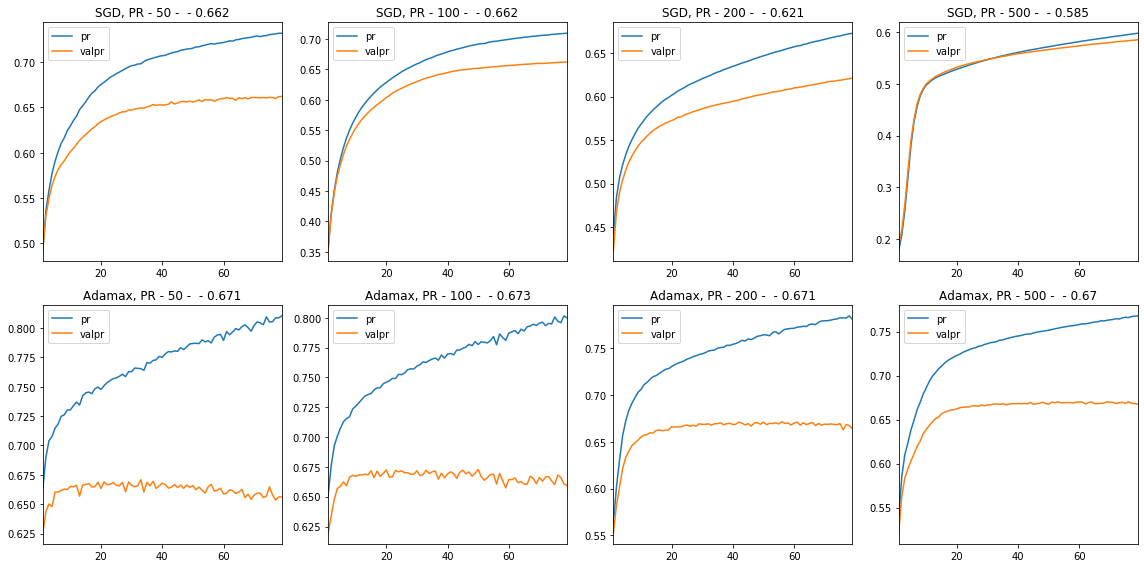

In [64]:
opti = ["SGD", "Adamax"]
batchSizes = [50, 100, 200, 500]

fig, ax = plt.subplots(2, 4, figsize=(16,8))

n = 2
nu1 = 100
nu2 = 40
nu3 = 10

for i, opt in enumerate(opti):
    for j, batch in enumerate(batchSizes):
        ROC, PR, bestTrainProba, bestTestProba, history = net(X_train, X_valid, features_eng, n=n, nu1=nu1, nu2=nu2, nu3=nu3,
                                    epochs = 80, batchSize=batch, optimizer=opt, debug=False)
        print('{}, batch: {}, PR: {}'.format(opt, batch, PR))
        history = pd.DataFrame(history)
        history.loc[1:, ["pr", "valpr"]].plot(ax = ax[i, j])
        ax[i, j].set_title(opt+ ", PR - " + str(batch) + " - "+ " - " + str(round(PR, 3)))

        
        
plt.tight_layout()
plt.show()

SGD, batch: 50, PR: 0.6626907891648033
SGD, batch: 100, PR: 0.6596736081569301
SGD, batch: 200, PR: 0.6192317985517299
SGD, batch: 500, PR: 0.5631478336617065
Adamax, batch: 50, PR: 0.6714794783679624
Adamax, batch: 100, PR: 0.6702825880766659
Adamax, batch: 200, PR: 0.6694164020765042
Adamax, batch: 500, PR: 0.6664298328625351


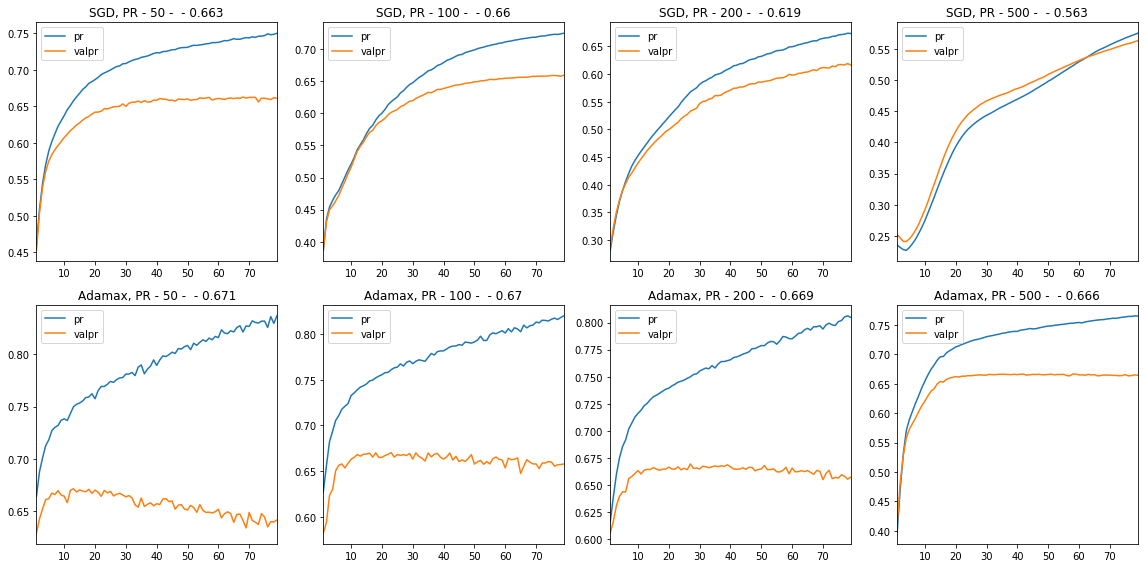

In [65]:
opti = ["SGD", "Adamax"]
batchSizes = [50, 100, 200, 500]

fig, ax = plt.subplots(2, 4, figsize=(16,8))

n = 3
nu1 = 100
nu2 = 40
nu3 = 10

for i, opt in enumerate(opti):
    for j, batch in enumerate(batchSizes):
        ROC, PR, bestTrainProba, bestTestProba, history = net(X_train, X_valid, features_eng, n=n, nu1=nu1, nu2=nu2, nu3=nu3,
                                    epochs = 80, batchSize=batch, optimizer=opt, debug=False)
        print('{}, batch: {}, PR: {}'.format(opt, batch, PR))
        history = pd.DataFrame(history)
        history.loc[1:, ["pr", "valpr"]].plot(ax = ax[i, j])
        ax[i, j].set_title(opt+ ", PR - " + str(batch) + " - "+ " - " + str(round(PR, 3)))

        
        
plt.tight_layout()
plt.show()

Podobne wnioski jak przy testowaniu optymalizatorów, lepiej wygląda proces trenowania dwuwarstwowej sieci, ale z batch size 200 z trójwarstwową nie jest najgorzej. W obydwu przypadkach batch size ok 200 będzie optymalnym wyborem.<br/>
##### Funkcje aktywacji.

funkcja: tanh, PR: 0.679434360624244
funkcja: sigmoid, PR: 0.6534051888655256
funkcja: linear, PR: 0.6523851187908016
funkcja: relu, PR: 0.6705518590013863
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
funkcja: selu, PR: 0.6762426803006019
funkcja: prelu, PR: 0.6668616913644863


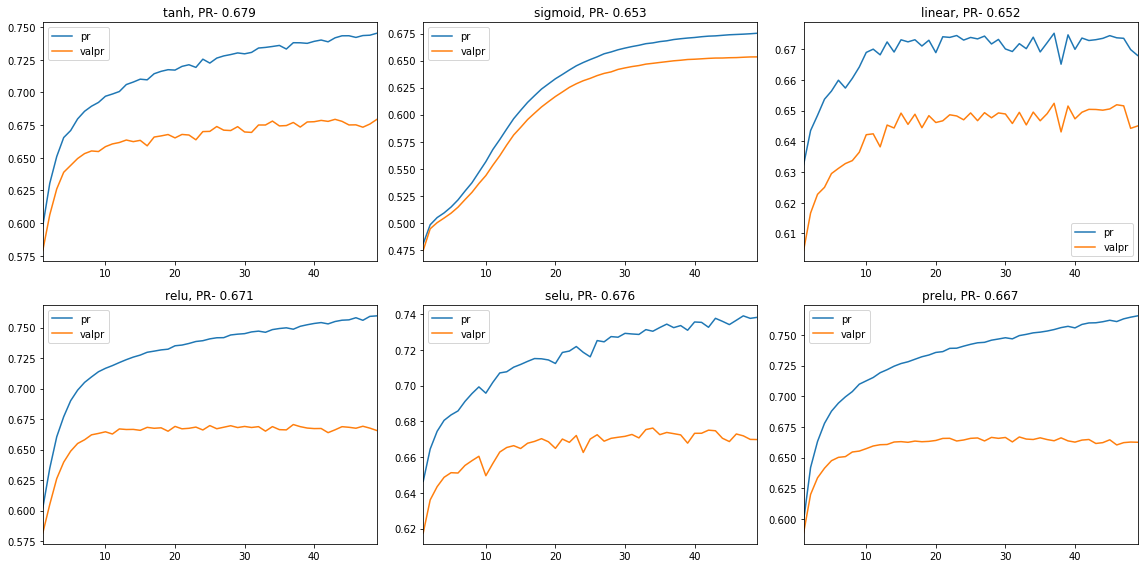

In [67]:
activations = ["tanh", "sigmoid", "linear", "relu", "selu", "prelu"]

fig, ax = plt.subplots(2, 3, figsize=(16,8))
ax = ax.flatten()
n = 2
nu1 = 100
nu2 = 40
nu3 = 10

for i, acti in enumerate(activations):
    ROC, PR, bestTrainProba, bestTestProba, history = net(X_train, X_valid, features_eng, n=n, nu1=nu1, nu2=nu2, nu3=nu3,
                                    epochs = 50, batchSize=200, optimizer="Adamax", activation=acti, debug=False)
    
    print('funkcja: {}, PR: {}'.format(acti, PR))
    history = pd.DataFrame(history)
    history.loc[1:, ["pr", "valpr"]].plot(ax = ax[i])
    ax[i].set_title(str(acti)+ ", PR- " + str(round(PR, 3)))

plt.tight_layout()
plt.show()

funkcja: tanh, PR: 0.6845501115032857
funkcja: sigmoid, PR: 0.6519517708848713
funkcja: linear, PR: 0.653496787192582
funkcja: relu, PR: 0.6684286316709398
funkcja: selu, PR: 0.6777721260427142
funkcja: prelu, PR: 0.671066499175839


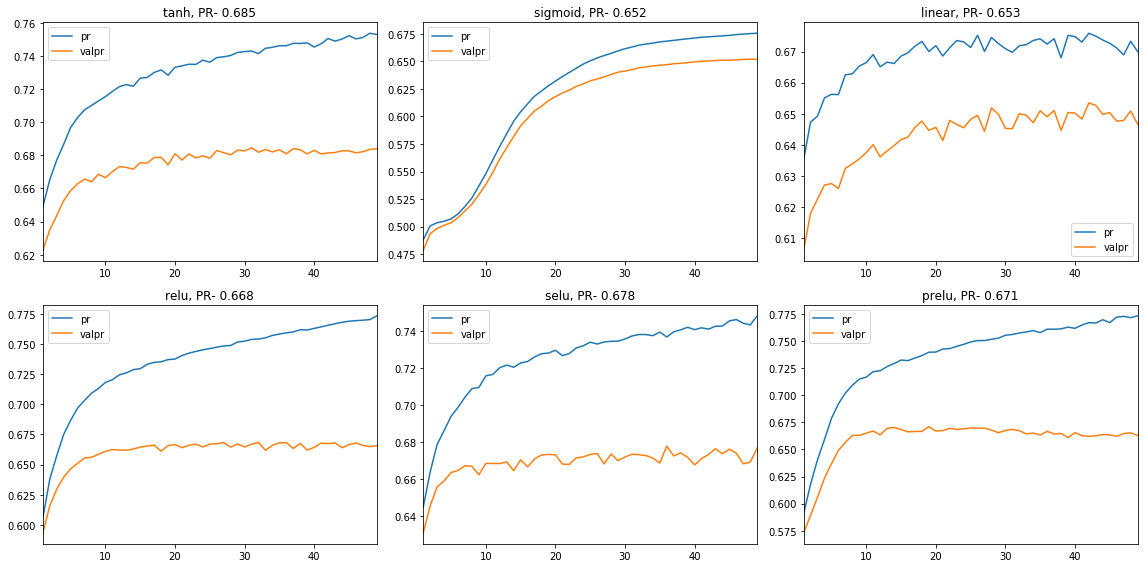

In [68]:
activations = ["tanh", "sigmoid", "linear", "relu", "selu", "prelu"]

fig, ax = plt.subplots(2, 3, figsize=(16,8))
ax = ax.flatten()
n = 3
nu1 = 100
nu2 = 40
nu3 = 10

for i, acti in enumerate(activations):
    ROC, PR, bestTrainProba, bestTestProba, history = net(X_train, X_valid, features_eng, n=n, nu1=nu1, nu2=nu2, nu3=nu3,
                                    epochs = 50, batchSize=200, optimizer="Adamax", activation=acti, debug=False)
    
    print('funkcja: {}, PR: {}'.format(acti, PR))
    history = pd.DataFrame(history)
    history.loc[1:, ["pr", "valpr"]].plot(ax = ax[i])
    ax[i].set_title(str(acti)+ ", PR- " + str(round(PR, 3)))

plt.tight_layout()
plt.show()

Relu i Prelu to jedyne funkcje, które warto rozpatrywać (najgładsza historia przy najwyższych wynikach). Dalsze testy przeprowadzone zostaną na Relu (wypada odrobinę lepiej).
##### Regularyzacja

regu: 0 PR: 0.6718310297438025, ROC: 0.842211883571662
regu: 0.001 PR: 0.675791307653549, ROC: 0.8471239224514431
regu: 0.05 PR: 0.6755004665216604, ROC: 0.8461785091105647
regu: 0.1 PR: 0.6715058904892891, ROC: 0.8463216912759586
regu: 0.2 PR: 0.6651000648749259, ROC: 0.8422653199778855
regu: 0.5 PR: 0.656159377075766, ROC: 0.841529541769115


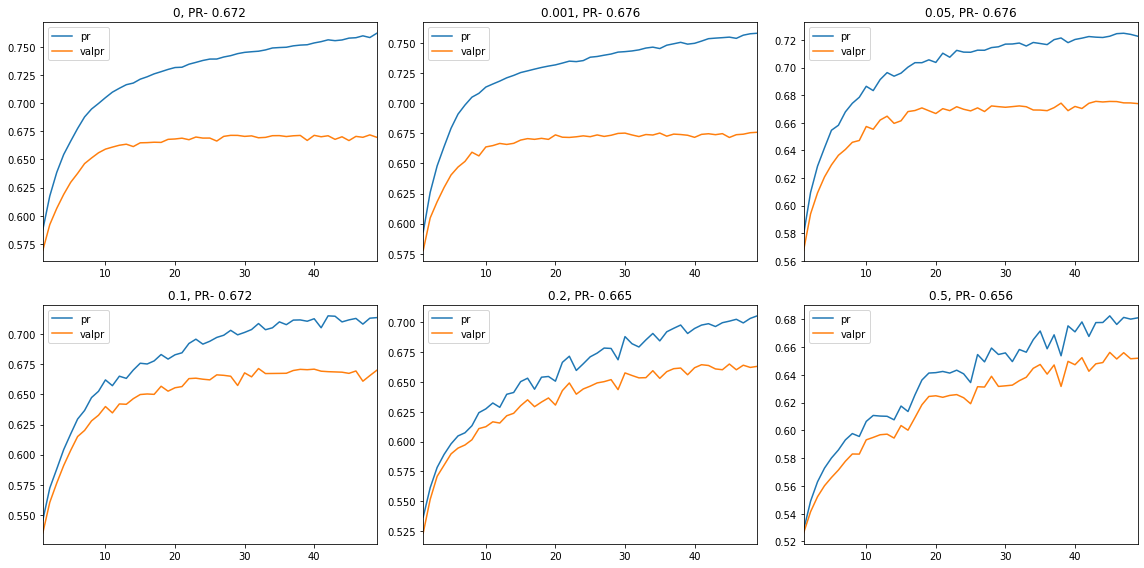

In [69]:
reguRates = [0, 0.001, 0.05, 0.1, 0.2, 0.5]

fig, ax = plt.subplots(2, 3, figsize=(16,8))
ax = ax.flatten()
n = 2
nu1 = 100
nu2 = 40
nu3 = 10

for i, reguRate in enumerate(reguRates):
    
    ROC, PR, bestTrainProba, bestTestProba, history = net(X_train, X_valid, features_eng, n=n, nu1=nu1, nu2=nu2, nu3=nu3,
                                    epochs = 50, batchSize=200, optimizer="Adamax", activation='relu',
                                                          regu = reguRate, debug=False)
    
    print('regu: {} PR: {}, ROC: {}'.format(reguRate, PR, ROC))
    history = pd.DataFrame(history)
    
    history.loc[1:, ["pr", "valpr"]].plot(ax = ax[i])
    ax[i].set_title(str(reguRate)+ ", PR- " + str(round(PR, 3)))

    

plt.tight_layout()
plt.show()

Niewielka regularyzacja może przynieść dobre skutki (nieregularny kształt będzie można zredukować dropoutem). Najlepsze wyniki sieć osiągała dla regularyzacji L2 0-0.05.
###### Dropout

dropout rate: 0 PR: 0.6686375421849374, ROC: 0.8436498709647804
dropout rate: 0.2 PR: 0.6699627078064474, ROC: 0.8447535382779364
dropout rate: 0.4 PR: 0.6690563786755543, ROC: 0.8456064655311203
dropout rate: 0.5 PR: 0.6683439121699501, ROC: 0.8446672179294215
dropout rate: 0.6 PR: 0.6677305496518984, ROC: 0.8431874405263075
dropout rate: 0.8 PR: 0.6550268099258927, ROC: 0.8412959287624198


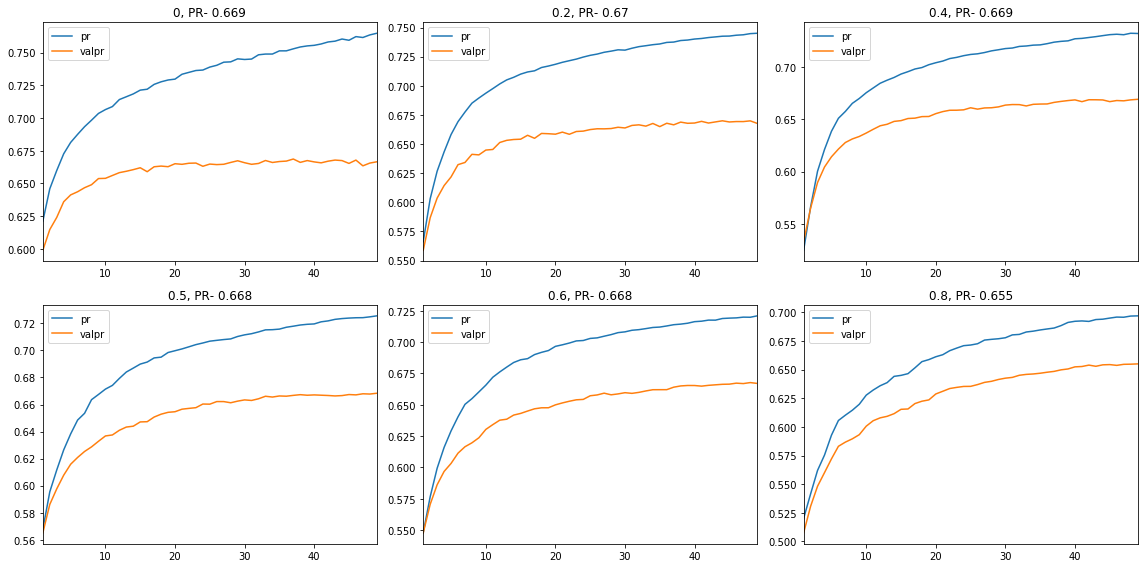

In [70]:
dropRates = [0, 0.2, 0.4, 0.5, 0.6, 0.8]

fig, ax = plt.subplots(2, 3, figsize=(16,8))
ax = ax.flatten()
n = 2
nu1 = 100
nu2 = 40
nu3 = 10

for i, dropRate in enumerate(dropRates):
    
    ROC, PR, bestTrainProba, bestTestProba, history = net(X_train, X_valid, features_eng, n=n, nu1=nu1, nu2=nu2, nu3=nu3,
                                    epochs = 50, batchSize=200, optimizer="Adamax", activation='relu',
                                                          dropout_rate=dropRate, debug=False)
    
    print('dropout rate: {} PR: {}, ROC: {}'.format(dropRate, PR, ROC))
    history = pd.DataFrame(history)
    history.loc[1:, ["pr", "valpr"]].plot(ax = ax[i])
    ax[i].set_title(str(dropRate)+ ", PR- " + str(round(PR, 3)))

    

plt.tight_layout()
plt.show()

Najlepsze wyniki z dropoutem 0-0.4, (warto pamiętać o tym, że wyniki nie są powtarzalne, ze względu na różną inicjację parametrów sieci, dlatego występują różnice między kilkukrotnym uruchomieniem tej samej sieci).<br/>
Dropout na wszystkich warstwach.

dropout rate: 0 PR: 0.6750915425494394, ROC: 0.8428147558470047
dropout rate: 0.2 PR: 0.6663558465871958, ROC: 0.8436567217860913
dropout rate: 0.4 PR: 0.6666510343725096, ROC: 0.8443226216174926
dropout rate: 0.5 PR: 0.6676949770953744, ROC: 0.8451125213146178
dropout rate: 0.6 PR: 0.6607569989294123, ROC: 0.8424859164240905
dropout rate: 0.8 PR: 0.6084879994436554, ROC: 0.8218224691867184


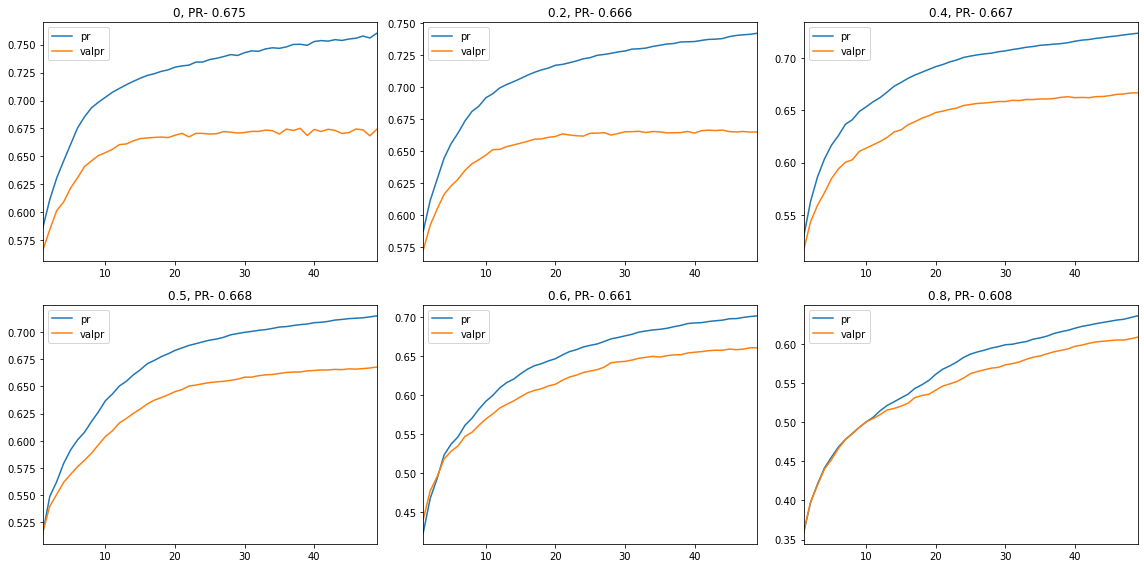

In [71]:
dropRates = [0, 0.2, 0.4, 0.5, 0.6, 0.8]

fig, ax = plt.subplots(2, 3, figsize=(16,8))
ax = ax.flatten()
n = 2
nu1 = 100
nu2 = 40
nu3 = 10

for i, dropRate in enumerate(dropRates):
    
    ROC, PR, bestTrainProba, bestTestProba, history = net(X_train, X_valid, features_eng, n=n, nu1=nu1, nu2=nu2, nu3=nu3,
                                    epochs = 50, batchSize=200, optimizer="Adamax", activation='relu',
                                                          dropout_rate=dropRate, dropout_all_layers = True, debug=False)
    
    print('dropout rate: {} PR: {}, ROC: {}'.format(dropRate, PR, ROC))
    history = pd.DataFrame(history)
    history.loc[1:, ["pr", "valpr"]].plot(ax = ax[i])
    ax[i].set_title(str(dropRate)+ ", PR- " + str(round(PR, 3)))

    

plt.tight_layout()
plt.show()

Brak wyraźnej poprawy, na powyższym uruchomieniu z dropoutem 0 widać jakiego rodzaju różnice są możliwe w zależności od inicjacji parametrów.<br/>
Dropout i regularyzacja.

dropout rate: 0 PR: 0.676850018594574, ROC: 0.8463936248997211
dropout rate: 0.2 PR: 0.6765234386073488, ROC: 0.847363701197318
dropout rate: 0.4 PR: 0.6757347763762741, ROC: 0.8451577367352685
dropout rate: 0.5 PR: 0.6715459729252732, ROC: 0.8464682988520078
dropout rate: 0.6 PR: 0.6762342712368372, ROC: 0.8474671485991098
dropout rate: 0.8 PR: 0.6635586202988774, ROC: 0.8440184451512969


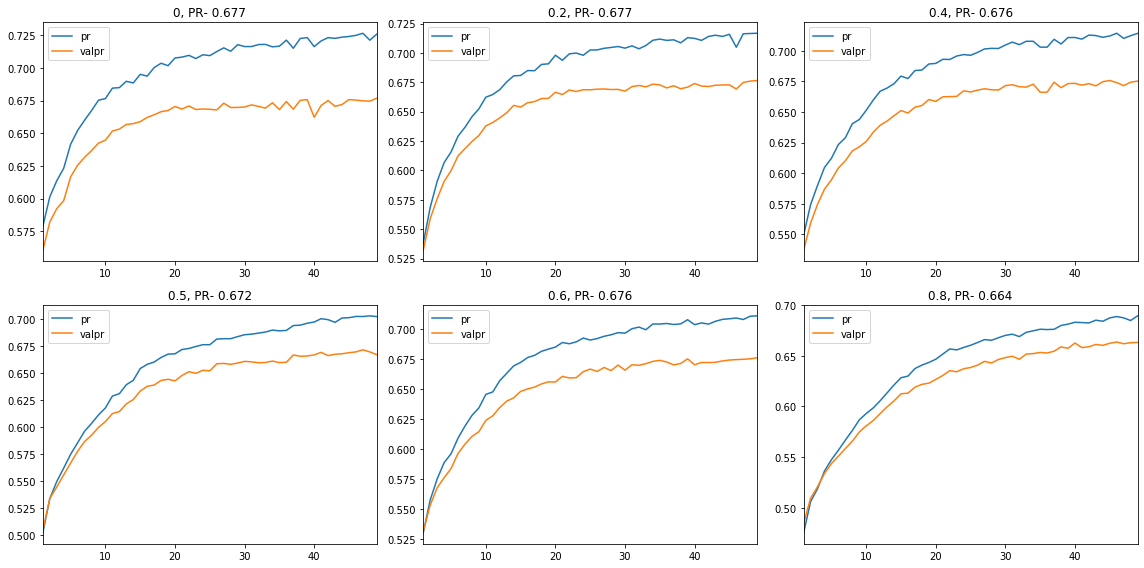

In [72]:
dropRates = [0, 0.2, 0.4, 0.5, 0.6, 0.8]

fig, ax = plt.subplots(2, 3, figsize=(16,8))
ax = ax.flatten()
n = 2
nu1 = 100
nu2 = 40
nu3 = 10

for i, dropRate in enumerate(dropRates):
    
    ROC, PR, bestTrainProba, bestTestProba, history = net(X_train, X_valid, features_eng, n=n, nu1=nu1, nu2=nu2, nu3=nu3,
                                    epochs = 50, batchSize=200, optimizer="Adamax", activation='relu',
                                                          dropout_rate=dropRate, dropout_all_layers = False,
                                                          regu = 0.05, debug=False)
    
    print('dropout rate: {} PR: {}, ROC: {}'.format(dropRate, PR, ROC))
    history = pd.DataFrame(history)
    history.loc[1:, ["pr", "valpr"]].plot(ax = ax[i])
    ax[i].set_title(str(dropRate)+ ", PR- " + str(round(PR, 3)))
    

plt.tight_layout()
plt.show()

dropout rate: 0 PR: 0.6761668963286593, ROC: 0.8460092938241902
dropout rate: 0.2 PR: 0.678067962867365, ROC: 0.8473205410230605
dropout rate: 0.4 PR: 0.6769796279305373, ROC: 0.8461572715645016
dropout rate: 0.5 PR: 0.6751490227210768, ROC: 0.8468519448454077
dropout rate: 0.6 PR: 0.6736737446851472, ROC: 0.8469478563437578
dropout rate: 0.8 PR: 0.6693604080634533, ROC: 0.8459829181621439


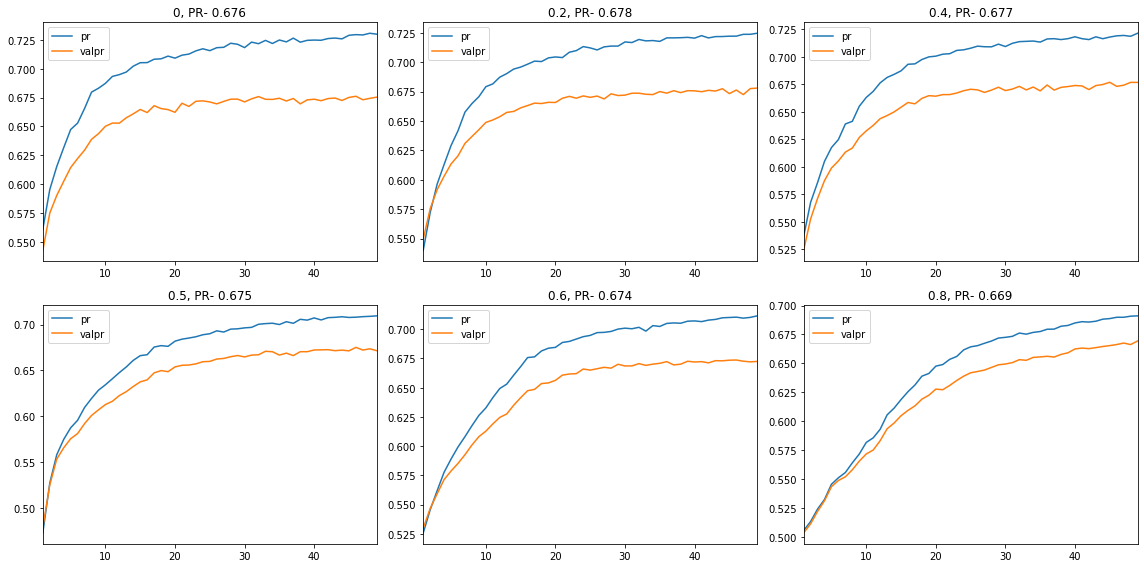

In [73]:
dropRates = [0, 0.2, 0.4, 0.5, 0.6, 0.8]

fig, ax = plt.subplots(2, 3, figsize=(16,8))
ax = ax.flatten()
n = 2
nu1 = 100
nu2 = 40
nu3 = 10

for i, dropRate in enumerate(dropRates):
    
    ROC, PR, bestTrainProba, bestTestProba, history = net(X_train, X_valid, features_eng, n=n, nu1=nu1, nu2=nu2, nu3=nu3,
                                    epochs = 50, batchSize=200, optimizer="Adamax", activation='relu',
                                                          dropout_rate=dropRate, dropout_all_layers = False,
                                                          regu = 0.025, debug=False)
    
    print('dropout rate: {} PR: {}, ROC: {}'.format(dropRate, PR, ROC))
    history = pd.DataFrame(history)
    history.loc[1:, ["pr", "valpr"]].plot(ax = ax[i])
    ax[i].set_title(str(dropRate)+ ", PR- " + str(round(PR, 3)))
    

plt.tight_layout()
plt.show()

Dropout w okolicach 0-0.4 z niewielką regularyzacją 0-0.05 przynosi najlepsze rezultaty. Poniżej analogiczne ćwiczenie dla sieci trójwarstwowej. 

dropout rate: 0 PR: 0.6730740721661878, ROC: 0.8455708412603046
dropout rate: 0.2 PR: 0.681641192567646, ROC: 0.8461271279507343
dropout rate: 0.4 PR: 0.6769247427900893, ROC: 0.8480987943239575
dropout rate: 0.5 PR: 0.676640850972949, ROC: 0.8464039011316872
dropout rate: 0.6 PR: 0.6736841335253042, ROC: 0.8477404963694073
dropout rate: 0.8 PR: 0.6724344748021462, ROC: 0.8462956581549779


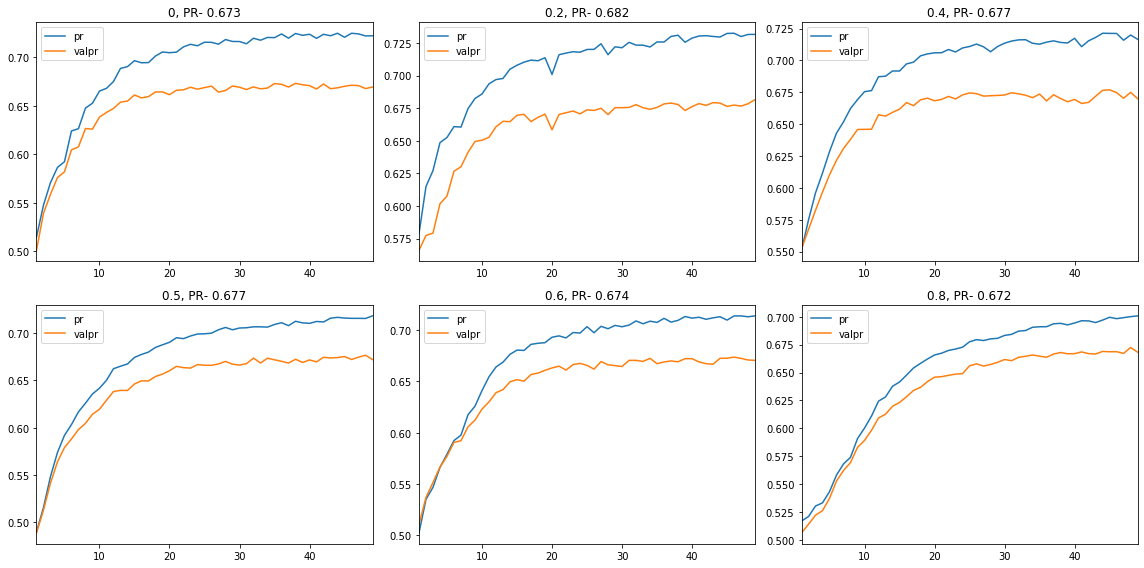

In [74]:
dropRates = [0, 0.2, 0.4, 0.5, 0.6, 0.8]

fig, ax = plt.subplots(2, 3, figsize=(16,8))
ax = ax.flatten()
n = 3
nu1 = 100
nu2 = 40
nu3 = 10

for i, dropRate in enumerate(dropRates):
    
    ROC, PR, bestTrainProba, bestTestProba, history = net(X_train, X_valid, features_eng, n=n, nu1=nu1, nu2=nu2, nu3=nu3,
                                    epochs = 50, batchSize=200, optimizer="Adamax", activation='relu',
                                                          dropout_rate=dropRate, dropout_all_layers = False,
                                                          regu = 0.05, debug=False)
    
    print('dropout rate: {} PR: {}, ROC: {}'.format(dropRate, PR, ROC))
    history = pd.DataFrame(history)
    history.loc[1:, ["pr", "valpr"]].plot(ax = ax[i])
    ax[i].set_title(str(dropRate)+ ", PR- " + str(round(PR, 3)))
    

plt.tight_layout()
plt.show()

dropout rate: 0 PR: 0.677674930205844, ROC: 0.847364386279449
dropout rate: 0.2 PR: 0.6769147159593026, ROC: 0.8487201638168392
dropout rate: 0.4 PR: 0.6799936657688093, ROC: 0.8489510364950102
dropout rate: 0.5 PR: 0.6755957062304385, ROC: 0.8462655145412107
dropout rate: 0.6 PR: 0.6773862050122681, ROC: 0.8470663755524332
dropout rate: 0.8 PR: 0.6728443817882855, ROC: 0.8455434379750616


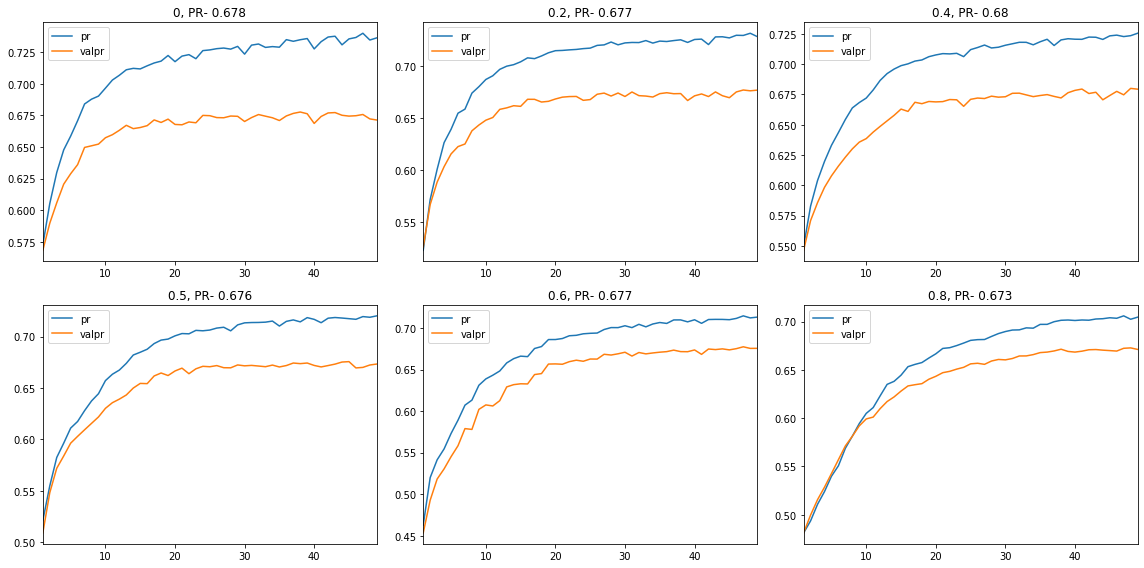

In [75]:
dropRates = [0, 0.2, 0.4, 0.5, 0.6, 0.8]

fig, ax = plt.subplots(2, 3, figsize=(16,8))
ax = ax.flatten()
n = 3
nu1 = 100
nu2 = 40
nu3 = 10

for i, dropRate in enumerate(dropRates):
    
    ROC, PR, bestTrainProba, bestTestProba, history = net(X_train, X_valid, features_eng, n=n, nu1=nu1, nu2=nu2, nu3=nu3,
                                    epochs = 50, batchSize=200, optimizer="Adamax", activation='relu',
                                                          dropout_rate=dropRate, dropout_all_layers = False,
                                                          regu = 0.025, debug=False)
    
    print('dropout rate: {} PR: {}, ROC: {}'.format(dropRate, PR, ROC))
    history = pd.DataFrame(history)
    history.loc[1:, ["pr", "valpr"]].plot(ax = ax[i])
    ax[i].set_title(str(dropRate)+ ", PR- " + str(round(PR, 3)))
    

plt.tight_layout()
plt.show()

Dla sieci trójwarstowych potrzebna jest nieco mniejsza regularyzacja (proces uczenia się jest wtedy mniej losowy).
##### Walidacja krzyżowa sieci neuronowych

In [76]:
def CVTestNN(df = dffin, nFolds = 5, randomState=2020, features=features_eng, target = 'Exited', debug=False, *args, **kwargs):
    
    # warstwowa walidacja krzyżowa
    kf = StratifiedKFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # listy na wyniki
    ROCtestResults = []
    ROCtrainResults = []
    PRtestResults = []
    PRtrainResults = []
    predictions = []
    indices = []
    
    # historia uczenia
    hists = []
    
    fold = 1
    for train, test in kf.split(df.index.values, df[target]):
        # Przygotowanie estymatora
        ROC, PR, trainPred, testPred, history = net(df.iloc[train], df.iloc[test], features,
                                                              target, debug = False, *args, **kwargs)        
 

        # zapis predykcji i indeksów
        predictions.append(testPred.copy())
        indices.append(df.iloc[test].index.tolist().copy())
        
        # obliczenie metryk
        ROCtrainScore = roc_auc_score(df[target].iloc[train], trainPred)
        ROCtestScore = roc_auc_score(df[target].iloc[test], testPred)
        PRtrainScore = average_precision_score(df[target].iloc[train], trainPred)
        PRtestScore = average_precision_score(df[target].iloc[test], testPred)
        
        # zapisanie metryk
        ROCtrainResults.append(ROCtrainScore)
        ROCtestResults.append(ROCtestScore)
        PRtrainResults.append(PRtrainScore)
        PRtestResults.append(PRtestScore)
        
        # zapisanie historii
        hists.append(history)
        fold+=1
        
    return ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices, hists

Pierwsza walidacja dla sekwencyjnie ustalonych parametrów.

In [78]:
start = time.time()

ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices, hists = CVTestNN(
    df = dffin, features=features_eng, n=2, nu1=100, nu2=40, nu3=10,epochs = 50, batchSize=200, optimizer="Adamax",
    activation="relu",dropout_rate=0.2, dropout_all_layers=False, regu=0.025, debug=False)

stop = time.time()

print('ROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format(
        np.mean(ROCtestResults),
        np.mean(PRtestResults), 
        np.mean(ROCtrainResults)-np.mean(ROCtestResults),
        np.mean(PRtrainResults)-np.mean(PRtestResults)))
print('\nUczenie trwało: {} sekund'.format(stop-start))

nROC: 0.863180281018835
PR: 0.7003066340940156
ROCtrain-test: 0.0070001609323023795
PRtrain-test: 0.010626401522359719

Uczenie trwało: 71.44289827346802 sekund


##### Eksperymenty w walidacji krzyżowej

In [79]:
start = time.time()

ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices, hists = CVTestNN(
    df = dffin, features=features_eng, n=2, nu1=100, nu2=40, nu3=10,epochs = 50, batchSize=200, optimizer="Adamax",
    activation="prelu",dropout_rate=0.2, dropout_all_layers=False, regu=0.025, debug=False)

stop = time.time()

print('ROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format(
        np.mean(ROCtestResults),
        np.mean(PRtestResults), 
        np.mean(ROCtrainResults)-np.mean(ROCtestResults),
        np.mean(PRtrainResults)-np.mean(PRtestResults)))
print('\nUczenie trwało: {} sekund'.format(stop-start))

ROC: 0.863508787933081
PR: 0.7009376462880427
ROCtrain-test: 0.006770804822113674
PRtrain-test: 0.010611934146200208

Uczenie trwało: 80.0713906288147 sekund


In [80]:
start = time.time()

ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices, hists = CVTestNN(
    df = dffin, features=features_eng, n=3, nu1=100, nu2=40, nu3=10,epochs = 50, batchSize=200, optimizer="Adamax",
    activation="prelu",dropout_rate=0.3, dropout_all_layers=False, regu=0.01, debug=False)

stop = time.time()

print('ROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format(
        np.mean(ROCtestResults),
        np.mean(PRtestResults), 
        np.mean(ROCtrainResults)-np.mean(ROCtestResults),
        np.mean(PRtrainResults)-np.mean(PRtestResults)))
print('\nUczenie trwało: {} sekund'.format(stop-start))

ROC: 0.8656042425340609
PR: 0.7053517926981023
ROCtrain-test: 0.010269347956409658
PRtrain-test: 0.01840047422628588

Uczenie trwało: 85.18030452728271 sekund


In [81]:
start = time.time()

ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices, hists = CVTestNN(
    df = dffin, features=features_eng, n=2, nu1=50, nu2=20, nu3=50,epochs = 50, batchSize=200, optimizer="Adamax",
    activation="relu",dropout_rate=0.3, dropout_all_layers=False, regu=0.05, debug=False)

stop = time.time()

print('ROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format(
        np.mean(ROCtestResults),
        np.mean(PRtestResults), 
        np.mean(ROCtrainResults)-np.mean(ROCtestResults),
        np.mean(PRtrainResults)-np.mean(PRtestResults)))
print('\nUczenie trwało: {} sekund'.format(stop-start))

ROC: 0.8610538383317564
PR: 0.6923454178837332
ROCtrain-test: 0.0024568638554613997
PRtrain-test: 0.0052502976607666785

Uczenie trwało: 73.80025792121887 sekund


In [82]:
start = time.time()

ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices, hists = CVTestNN(
    df = dffin, features=features_eng, n=3, nu1=100, nu2=40, nu3=10,epochs = 50, batchSize=200, optimizer="Adamax",
    activation="relu",dropout_rate=0.4, dropout_all_layers=False, regu=0.01, debug=False)

stop = time.time()

print('ROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format(
        np.mean(ROCtestResults),
        np.mean(PRtestResults), 
        np.mean(ROCtrainResults)-np.mean(ROCtestResults),
        np.mean(PRtrainResults)-np.mean(PRtestResults)))
print('\nUczenie trwało: {} sekund'.format(stop-start))

ROC: 0.8648399311989102
PR: 0.7028918257230659
ROCtrain-test: 0.008308095350935463
PRtrain-test: 0.015304891651634067

Uczenie trwało: 83.50031399726868 sekund


In [83]:
start = time.time()

ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices, hists = CVTestNN(
    df = dffin, features=features_eng, n=3, nu1=50, nu2=30, nu3=15,epochs = 50, batchSize=200, optimizer="Adamax",
    activation="prelu",dropout_rate=0.3, dropout_all_layers=False, regu=0.05, debug=False)

stop = time.time()

print('ROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format(
        np.mean(ROCtestResults),
        np.mean(PRtestResults), 
        np.mean(ROCtrainResults)-np.mean(ROCtestResults),
        np.mean(PRtrainResults)-np.mean(PRtestResults)))
print('\nUczenie trwało: {} sekund'.format(stop-start))

ROC: 0.8625091580005888
PR: 0.6969024476902821
ROCtrain-test: 0.005861709771458168
PRtrain-test: 0.010249959814263021

Uczenie trwało: 89.6415581703186 sekund


Najlepsze wyniki są zostały uzyskane na sieciach 100, 40, 10, trójwarstwowych z trochę wyższym dropoutem (0.3-0.4) i mniejszą regularyzacją (0.01), funkcje zarówno relu jak i prelu.<br/>
ponowne przetestowanie najlepszej sieci.

In [84]:
start = time.time()

ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices, hists = CVTestNN(
    df = dffin, features=features_eng, n=3, nu1=100, nu2=40, nu3=10,epochs = 50, batchSize=200, optimizer="Adamax",
    activation="prelu",dropout_rate=0.3, dropout_all_layers=False, regu=0.01, debug=False)

stop = time.time()

print('ROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format(
        np.mean(ROCtestResults),
        np.mean(PRtestResults), 
        np.mean(ROCtrainResults)-np.mean(ROCtestResults),
        np.mean(PRtrainResults)-np.mean(PRtestResults)))
print('\nUczenie trwało: {} sekund'.format(stop-start))

ROC: 0.8652062752850215
PR: 0.7054714902368846
ROCtrain-test: 0.011320085615650899
PRtrain-test: 0.019590651235156242

Uczenie trwało: 98.7083351612091 sekund


Wynik bardzo zbliżony, zatem można uznać tą sieć za najlepszą.<br/>
zapis modelu

In [89]:
model_NN_00 = {
    "name":"model_NN_00",
    "description":"Model Sieci Neuronowych z sekwencyjnie dobieranymi hiperparametrami ze zmiennymi po EDA",
    "specification":'n=3, nu1=100, nu2=40, nu3=10, batchSize=200, activation=prelu, dropout_rate=0.3 (1sza warstwa), regu=0.01',
    "ROCtrainResults":ROCtrainResults.copy(),
    "ROCtestResults":ROCtestResults.copy(),
    "PRtrainResults":PRtrainResults.copy(),
    "PRtestResults":PRtestResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
    "variables":features_eng.copy()
}


zapis_model_NN_00 = False

if zapis_model_NN_00:
    with open("model_NN_00.p", "wb") as fp:
        pickle.dump(model_NN_00, fp)

##### Porównanie modeli i ensembling najlepszych.

In [117]:
with open("model_logit_00.p", "rb") as fp:
    logit_00 = pickle.load(fp)
    
with open("model_logit_01.p", "rb") as fp:
    logit_01 = pickle.load(fp)

with open("model_RF_00.p", "rb") as fp:
    RF_00 = pickle.load(fp)
    
with open("model_RF_01.p", "rb") as fp:
    RF_01 = pickle.load(fp)
    
with open("model_RF_02.p", "rb") as fp:
    RF_02 = pickle.load(fp)
    
with open("model_XGB_00.p", "rb") as fp:
    XGB_00 = pickle.load(fp)
    
with open("model_XGB_01.p", "rb") as fp:
    XGB_01 = pickle.load(fp)
    
with open("model_NN_00.p", "rb") as fp:
    NN_00 = pickle.load(fp)

In [136]:
results = pd.DataFrame(columns = ['model', 'ROCtest', 'PRtest', 'PrzetrenowanieROC', 'PrzetrenowaniePR'])
for i in [logit_00, logit_01, RF_00, RF_01, RF_02, XGB_00, XGB_01, NN_00]:
    results = results.append(
        pd.DataFrame(
            np.array([
                i['name'],
                round(np.mean(i['ROCtestResults']), 4),
                round(np.mean(i['PRtestResults']), 4),
                round(np.mean(i['ROCtrainResults'])-np.mean(i['ROCtestResults']), 4),
                round(np.mean(i['PRtrainResults'])-np.mean(i['PRtestResults']), 4)
            ]).reshape(1,-1),
            columns = results.columns.tolist()),
        ignore_index = True)
    
results.sort_values(by = 'PRtest', ascending=False)

,model,ROCtest,PRtest,PrzetrenowanieROC,PrzetrenowaniePR
6,model_XGB_01,0.8705,0.7158,0.0358,0.0627
5,model_XGB_00,0.8688,0.713,0.0451,0.0746
7,model_NN_00,0.8652,0.7055,0.0113,0.0196
4,model_RF_02,0.8618,0.6955,0.071,0.1168
3,model_RF_01,0.8593,0.6937,0.0446,0.0763
2,model_RF_00,0.8485,0.6709,0.1515,0.3291
1,model_logit_01,0.8463,0.667,0.0017,0.0018
0,Logit_00,0.7648,0.4695,0.0029,0.0005


In [139]:
wyniki = pd.DataFrame(data = {
    'Logit':pd.Series(sum(logit_01['predictions'], []), index = sum(logit_01['indices'], [])).sort_index(),
    'RF':pd.Series(sum(RF_02['predictions'], []), index = sum(RF_02['indices'], [])).sort_index(),
    'XGB':pd.Series(sum(XGB_01['predictions'], []), index = sum(XGB_01['indices'], [])).sort_index(),
    'NN':pd.Series(sum(NN_00['predictions'], []), index = sum(NN_00['indices'], [])).sort_index(),
    'Observed':dffin['Exited']
})

predykcje = ['Logit', 'RF', 'XGB', 'NN']
wyniki

,Logit,RF,XGB,NN,Observed
0,0.281082,0.280964,0.269209,0.363747,1
1,0.238050,0.209962,0.171102,0.198118,0
2,0.944498,0.912059,0.895435,0.957954,1
3,0.092086,0.090734,0.059652,0.040995,0
4,0.256683,0.196987,0.128193,0.163847,0
...,...,...,...,...,...
9995,0.055343,0.027280,0.037789,0.024921,0
9996,0.055219,0.080639,0.062742,0.075751,0
9997,0.112169,0.155574,0.187647,0.142425,1
9998,0.224372,0.093329,0.091406,0.121773,1


In [140]:
print('predykcje max:\n{}'.format(wyniki[predykcje].idxmax(axis=1).value_counts()))

print('\npredykcje min:\n{}'.format(wyniki[predykcje].idxmin(axis=1).value_counts()))

predykcje max:
Logit    3454
RF       2905
XGB      1976
NN       1665
dtype: int64

predykcje min:
NN       3179
Logit    3172
RF       2256
XGB      1393
dtype: int64


modele są dość zróżnicowane, najbardziej skrajne wartości przyjmuje logit, sieć neuronowa jest najpewniejsza przy predykcji "0", w przeciwieństwie do XGB, RF w obu przypadkach jest po środku. Wyniki ensemblingu mogą być bardzo ciekawe.<br/>
Próba oszacowania logitu Exited na predykcjach.

In [141]:
import statsmodels.api as sm
mod = sm.GLM.from_formula(formula="Observed ~ "+"+".join(predykcje),
                          data=wyniki, family=sm.families.Binomial())
res = mod.fit()
predsStack = res.predict()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Observed   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9995
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3357.3
Date:                Mon, 08 Jun 2020   Deviance:                       6714.6
Time:                        18:07:36   Pearson chi2:                 9.11e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.0237      0.053    -57.505      0.000      -3.127      -2.921
Logit         -0.1948      0.344     -0.566      0.571      -0.869       0.479
RF            -0.4503      0.601     -0.749      0.454      -1.628       0.728
XGB            5.3687      0.618      8.682      0.000       4.157       6.581
NN             1.6564      0.498      3.326      0.001       0.680       2.632
==============================================================================
"""

Oszacowania i p_value podpowiadają, ze najważniejszymi modelami są XGB i NN.

In [143]:
wyniki["pred_mean"] = wyniki[predykcje].mean(axis=1)

In [145]:
print('średnie PR: {}\nśrednie ROC: {}'.format(
    average_precision_score(wyniki['Observed'], wyniki.pred_mean),
    roc_auc_score(wyniki['Observed'], wyniki.pred_mean)))

średnie PR: 0.706638737246535
średnie ROC: 0.8665928594269854


Zwykła średnia nie działa najlepiej, dlatego przeprowadzona zostanie symulacja wag.

In [153]:
import random

finalresults = pd.DataFrame(columns = ['a', 'b', 'c', 'd', 'ROC', 'PR'])

start = time.time()
for i in range(10000):
    a=random.randint(0,10)
    b=random.randint(0,10)
    c=random.randint(40,100)
    d=random.randint(40,100)

    mn = (a*wyniki["Logit"] + b*wyniki["RF"] + c*wyniki["NN"] + d*wyniki['XGB'])/(a+b+c+d)
    
    PR = average_precision_score(wyniki.Observed, mn)
    ROC =  roc_auc_score(wyniki.Observed, mn)


    finalresults = finalresults.append(
        other = pd.DataFrame(
            np.array([
                a,
                b,
                c,
                d,
                ROC,
                PR]).reshape(1, -1),
            columns = finalresults.columns.tolist()),
        ignore_index=True)

stop = time.time()
print('czas wykonania pętli: {}'.format(stop-start))
display(finalresults.sort_values(by = "PR", ascending = False).head(10))

czas wykonania pętli: 80.37774658203125


,a,b,c,d,ROC,PR
3047,0.0,0.0,40.0,97.0,0.870477,0.714555
9630,0.0,1.0,44.0,99.0,0.870456,0.714473
2984,0.0,0.0,40.0,86.0,0.870440,0.714465
6108,0.0,1.0,42.0,93.0,0.870450,0.714463
2220,0.0,0.0,47.0,100.0,0.870432,0.714450
4526,1.0,1.0,40.0,98.0,0.870427,0.714447
4602,0.0,0.0,42.0,87.0,0.870421,0.714446
6978,1.0,0.0,44.0,96.0,0.870413,0.714421
5593,0.0,2.0,40.0,89.0,0.870428,0.714393
4512,1.0,3.0,40.0,100.0,0.870416,0.714382


In [151]:
zapis_symulacja = False

if zapis_symulacja:
    with open("symulacja.p", "wb") as fp:
            pickle.dump(finalresults, fp)

Takie wyniki uzyskano podczas testów:

In [152]:
with open("symulacja.p", "rb") as fp:
    symulacja = pickle.load(fp)

display(symulacja.sort_values(by = 'PR', ascending = False).head(10))

,a,b,c,d,ROC,PR
6553,0.0,0.0,44.0,98.0,0.870459,0.714516
6586,1.0,0.0,40.0,95.0,0.870437,0.714486
1838,0.0,2.0,41.0,99.0,0.870450,0.714451
7287,0.0,2.0,42.0,97.0,0.870438,0.714409
7289,0.0,0.0,43.0,85.0,0.870399,0.714366
2097,2.0,0.0,45.0,99.0,0.870373,0.714359
9435,1.0,3.0,41.0,100.0,0.870406,0.714350
5473,2.0,2.0,40.0,99.0,0.870393,0.714345
7870,1.0,2.0,41.0,94.0,0.870404,0.714341
6332,0.0,3.0,42.0,96.0,0.870418,0.714339


Symulacja została przeprowadzona kilka razy i wyniki wyglądają na stabilne, mimo to powyżej można obejrzeć przykładowe wyniki. Takie rezultaty sugerują, że ensembling nie jest najlepszym rozwiązaniem w niniejszym problemie. XGB okazał się lepszy zarówno pod względem metryki PR jak i ROC i to on jest rozwiązaniem problemu modelowania churnu na tym przykładzie.

In [ ]:
kernelstop = time.time()
print('Uruchomienie całego kernela trwało: {}'.format(round(kernelstop-kernelstart), 2))

##### Wnioski:
Najlepszym rozwiązaniem problemu okazał się XGB na standardowych zmiennych. Poparcia nieprzydatności inżynierii można szukać w wynikach istotności kolumn (hiperparametr XGB) - na standardowych zmiennych 0.9, na nowych spadek do 0.5-0.7. Sieci Neuronowe były drugim najlepszym algorytmem, co prawda metryki nie były dużo wyższe niż w przypadku Random Forest (III najlepszy algorytm), ale w tym problemie ważna była metryka PR, a sieci miały na niej 10-cio krotnie mniejsze przetrenowanie. Bardzo możliwe, że z sieci neuronowych można wycisnąć znacznie więcej niż zostało to zrobione w niniejszym projekcie, podczas gdy Random Forest i XGB to algorytmy proste w obsłudze i jak pokazały eksperymenty, odporne na przeprowadzoną inżynierię. Najgorsze wyniki uzyskano na logicie, jednak na nim zaobserwowano kolosalną poprawę po manipulacji danymi i wyniki stały się porównywalne z Random Forest, jednocześnie zaletą logitu jest to, że jest transparenty co do swoich parametrów, które również można zinterpretować jako ilorazy szans lub efekty cząstkowe, zatem może być on wykorzystywany na produkcji w miejscu, gdzie trzeba trzeba będzie komuś wytłumaczyć wpływ zmiennej na prawdopodobieńśtwo churnu. 